# Dengue Analysis for Municipalities

## 0. Imports

### 0.1. Libraries

In [1]:
# Data manipulation libraries
import pandas                as pd
import numpy                 as np
import geopandas             as gpd

# Visualization libraries
import seaborn               as sns
import matplotlib            as mpl
import matplotlib.pyplot     as plt

from matplotlib              import cm
from matplotlib.colors       import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ESDA libraries
from esda.moran             import Moran, Moran_Local
from splot.esda             import moran_scatterplot, lisa_cluster
from splot.esda             import plot_moran, plot_local_autocorrelation

from libpysal.weights.contiguity import Queen
from splot.libpysal              import plot_spatial_weights

# Other
import warnings
import sys
import os

### 0.2. Settings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Directory Settings
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path     = os.path.join(project_root, 'src')
sys.path.append(src_path)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')  

# Customize rcParams
mpl.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 16,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 16,
    'xtick.bottom': False,
    'ytick.labelsize': 16,
    'ytick.left': False,
    'legend.fontsize': 16,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'font.size': 16,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'figure.titlesize': 24,
    'figure.figsize': (16,8),
    'figure.dpi': 150
})

### 0.3. Functions

In [3]:
def set_plot(fig, title, xlabel, ylabel):
    """
    Summary: This function sets the plot configuration for the initial plots. 
    Args:
        fig: the figure object.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
    Returns: figure with the image configuration.
    """
    # Customizing
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')

    return fig

def calculate_statistics(df, variable, start_year, end_year):
    """
    Summary: This function calculates the statistics for each year of a given variable and DataFrame.
    Args:
        df: DataFrame with the data.
        variable: The variable to calculate statistics.
        start_year: The start year for the statistics.
        end_year: The end year for the statistics.
    Returns: DataFrame with the statistics for each year.
    """
    # DataFrame to store the results
    df_statistics = pd.DataFrame()

    # Loop over the specified range of years
    for i in range(start_year, end_year + 1):
        stats = pd.DataFrame({
            'ano':      [i],
            'mean':     [df[df['ano'] == i][variable].mean()],
            'std':      [df[df['ano'] == i][variable].std()],
            'min':      [df[df['ano'] == i][variable].min()],
            'Q1':       [df[df['ano'] == i][variable].quantile(0.25)],
            'median':   [df[df['ano'] == i][variable].median()],
            'Q3':       [df[df['ano'] == i][variable].quantile(0.75)],
            'max':      [df[df['ano'] == i][variable].max()],
            'range':    [df[df['ano'] == i][variable].max() - df[df['ano'] == i][variable].min()]
        })

        # Append the statistics for this year to the results DataFrame
        df_statistics = pd.concat([df_statistics, stats], ignore_index=True)

    return df_statistics

def plot_taxa_incidencia_media(gdf, df_txinc, intervals, title, cmap='cividis', wspace=-0.25, hspace=None):
    """
    Summary: This function plots the mean incidence rate for each interval.
    Args:
        gdf: GeoDataFrame with the municipalities.
        df_txinc: DataFrame with the mean incidence rate by municipality and year.
        intervals: List of tuples with the years for the intervals.
        title: The title of the plot.
        cmap: The colormap for the choropleth map.
        wspace: The width space between subplots.
        hspace: The height space between subplots.
    Returns: figure with the image configuration.
    """

    aux_list = []
    for interval in intervals:
        aux = gdf.merge(
            df_txinc[df_txinc['ano'].isin(interval)].groupby(['id_mun'])['txinc'].mean().reset_index(), 
            on='id_mun'
        )
        aux_list.append(aux)
    
    # Plotting
    fig, axes = plt.subplots(2, 2)

    for i, ax in enumerate(axes.flat):
        aux_list[i].plot(ax=ax, column='txinc', cmap=cmap, legend=True)
        ax.set_title(f'{intervals[i][0]}-{intervals[i][-1]}')
    
    # Main title and spacing adjustments
    fig.suptitle(title)
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    
    plt.show()

### 0.4. Classes

### 0.5. Datasets

In [4]:
# Casos
df_casos = pd.read_csv('../data/interim/mun_dengue_casos_amazonia_legal.csv')

# Óbitos
df_obitos = pd.read_csv('../data/interim/mun_dengue_obitos_amazonia_legal.csv')

In [5]:
# População
df_pop = pd.read_csv('../data/interim/mun_populacao.csv')

In [6]:
# GeoDataFrame MU Brasil
gdf = gpd.read_file('../data/interim/amazonia_legal.geojson')

In [7]:
# Amazônia Legal Brasileira
alb = pd.read_csv('../data/interim/mun_amazonia_legal.csv')

## 1. Data Preparation

### Listas Auxiliares

In [8]:
# Lista de municípios da ALB
lista_mun_alb = alb.cod_ibge.to_list()

### Ajustando População

In [9]:
# Filtrando os dados
df_pop = df_pop[df_pop['cod_ibge'].isin(lista_mun_alb)]

# Ajustando os anos
df_pop['2023'] = df_pop['2022']

# Dropping 
df_pop.drop(columns=['nome_municipio', 'sigla_UF'], inplace=True)

# Melt
df_pop = pd.melt(df_pop, id_vars=['cod_ibge', 'id_mun'], var_name='ano', value_name='pop')

# Changing types
df_pop = df_pop.astype('int64')

### Taxa de Incidência

In [10]:
# Calculando taxa de incidência
df_txinc = pd.merge(df_pop, df_casos, on=['cod_ibge', 'id_mun', 'ano'], how='left')

# Corrigindo para municípios com anos faltantes que agora têm valor NaN
df_txinc = df_txinc.fillna(0)
df_txinc['casos'] = df_txinc['casos'].astype('int64')

# Casos / População * 100,000 habitantes
df_txinc['txinc'] = df_txinc['casos'] / df_txinc['pop'] * 100000

# Filtrando
df_txinc = df_txinc[['cod_ibge', 'id_mun', 'ano', 'txinc']]

# Corrigindo para municípios que não existiam 
df_txinc = df_txinc.fillna(0)

### Taxa de Mortalidade

### Taxa de Letalidade

## 2. Data Exploration

In [11]:
# Calculando estatísticas para Taxa de Incidência
df_txinc_stats = calculate_statistics(df_txinc, 'txinc', 2004, 2023)

# Display
df_txinc_stats

,ano,mean,std,min,Q1,median,Q3,max,range
0,2004,72.49,208.08,0.00,0.00,6.88,47.22,1848.67,1848.67
1,2005,141.31,360.39,0.00,0.00,22.01,108.99,5090.45,5090.45
2,2006,182.24,502.93,0.00,0.00,28.81,154.19,7992.20,7992.20
3,2007,354.03,689.45,0.00,15.69,103.84,367.17,7299.05,7299.05
4,2008,318.47,710.50,0.00,16.59,86.49,319.15,10229.65,10229.65
5,2009,455.30,981.47,0.00,8.95,67.87,364.01,7293.65,7293.65
6,2010,616.19,1126.62,0.00,17.04,134.82,678.26,9664.98,9664.98
7,2011,274.40,502.46,0.00,28.78,113.94,301.87,5421.69,5421.69
8,2012,394.89,757.12,0.00,20.95,113.39,398.67,7657.32,7657.32
9,2013,428.44,805.46,0.00,18.62,102.61,495.68,7139.02,7139.02


<Axes: xlabel='ano', ylabel='txinc'>

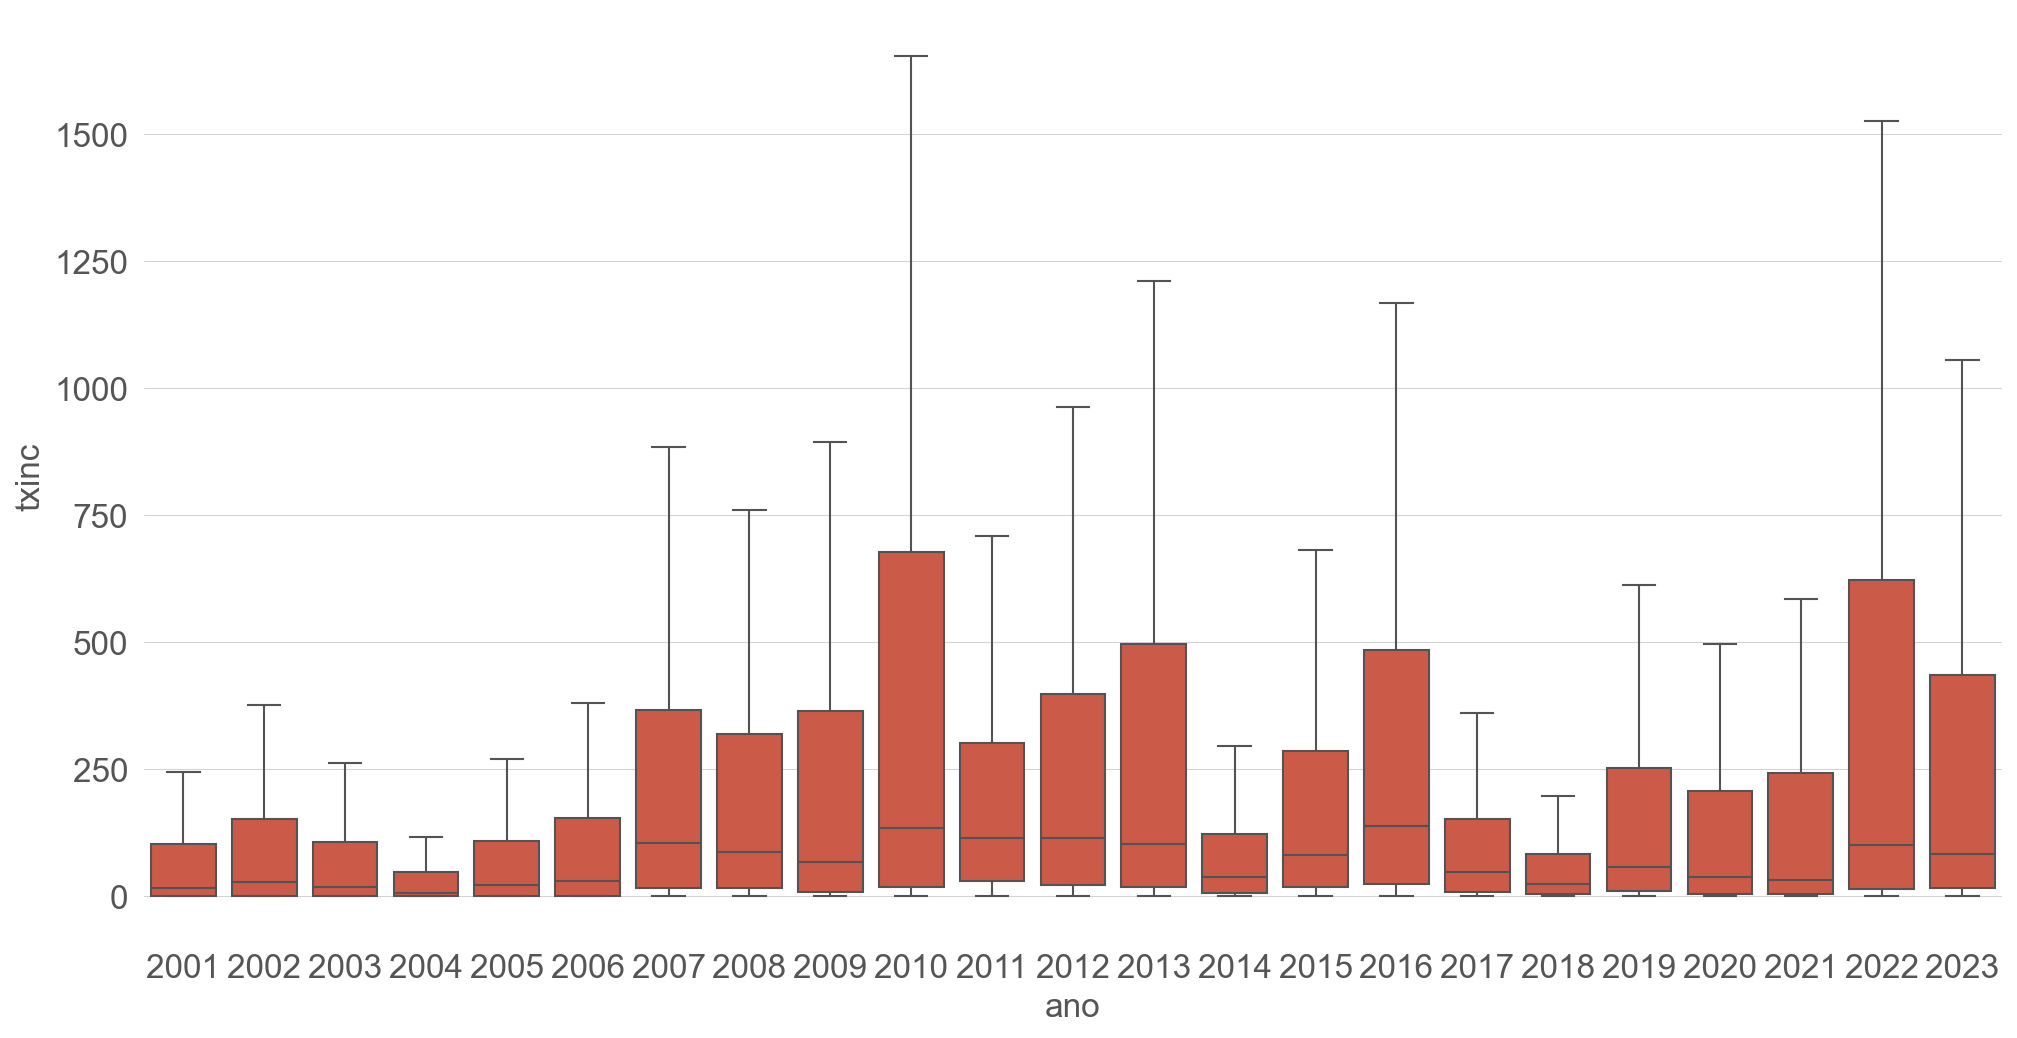

In [12]:
sns.boxplot(x='ano', y='txinc', data=df_txinc, showfliers=False)

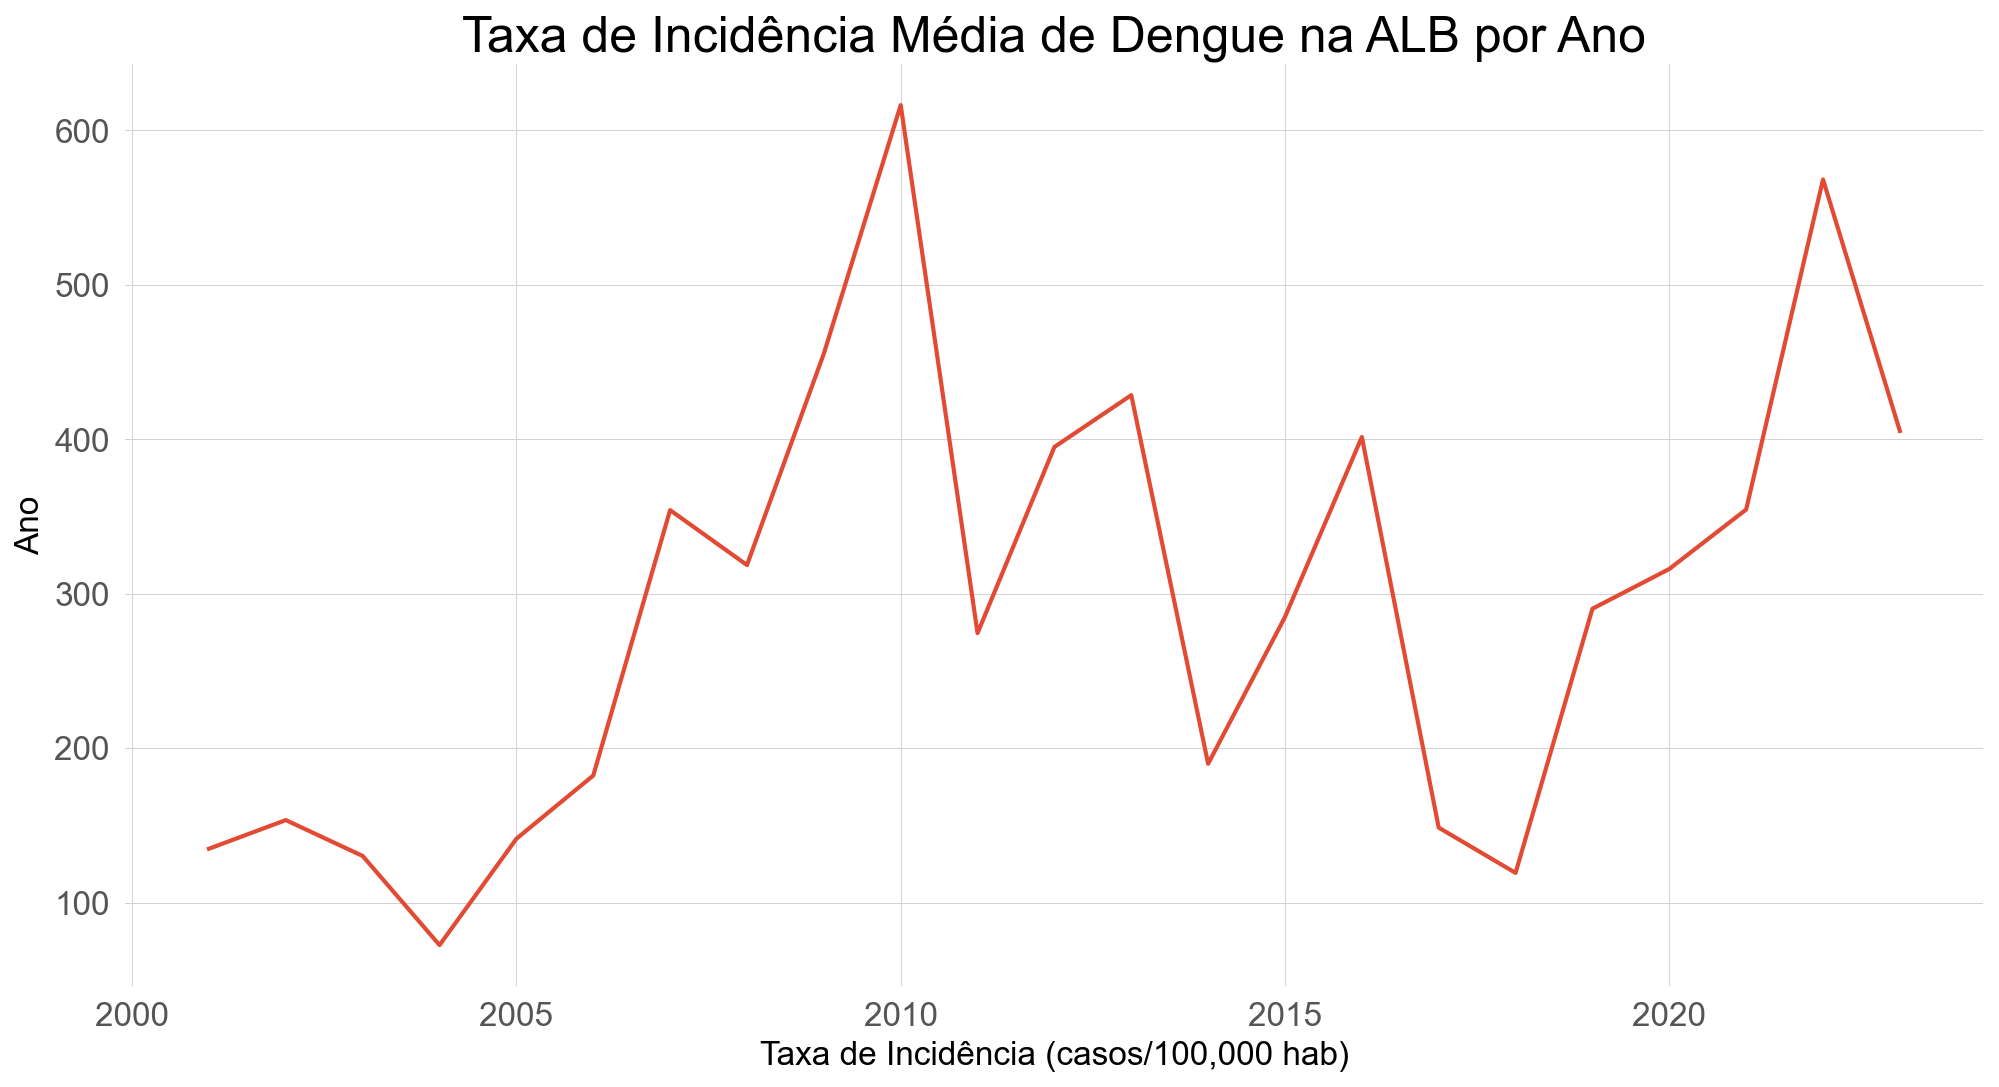

In [13]:
fig = df_txinc.groupby(['ano'])['txinc'].mean().plot()

fig = set_plot(
    fig,
    'Taxa de Incidência Média de Dengue na ALB por Ano',
    'Taxa de Incidência (casos/100,000 hab)',
    'Ano'
)

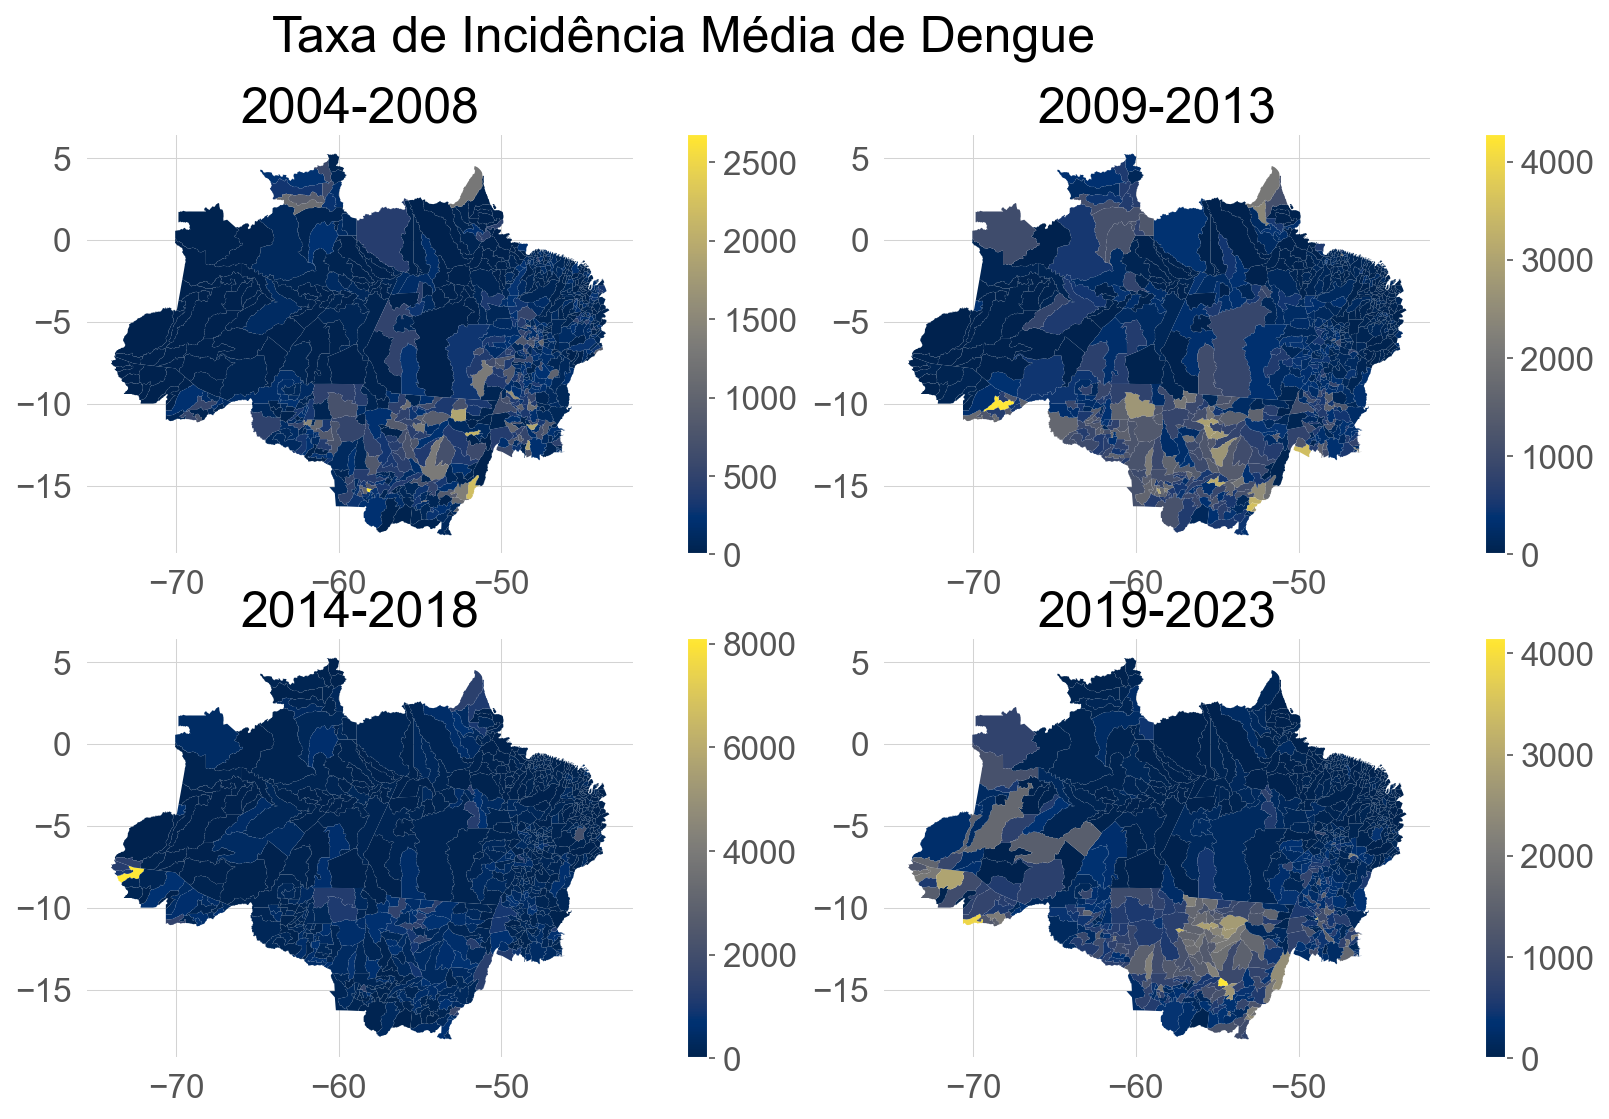

In [14]:
# Taxa de Incidência
intervals = [
    [2004, 2005, 2006, 2007, 2008],
    [2009, 2010, 2011, 2012, 2013],
    [2014, 2015, 2016, 2017, 2018],
    [2019, 2020, 2021, 2022, 2023]
]

plot_taxa_incidencia_media(
    gdf = gdf,
    df_txinc = df_txinc,
    intervals = intervals,
    title = 'Taxa de Incidência Média de Dengue'
)

In [15]:
def categorize(df, column):
    """
    """
    # Calculate the boxplot statistics
    Q1 = df[column].quantile(0.25)
    Median = df[column].median()
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    minimum = df[column].min()
    maximum = df[column].max()
    
    # Categories
    conditions = [
        (df[column] == minimum),
        (df[column] > minimum) & (df[column] <= Q1),
        (df[column] > Q1) & (df[column] <= Median),
        (df[column] > Median) & (df[column] <= Q3),
        (df[column] > Q3) & (df[column] < maximum),
        (df[column] == maximum)
    ]
    
    categories = [
        f"Min. ({round(minimum, 2)})",
        f"{round(minimum, 2)} - {round(Q1, 2)}",
        f"{round(Q1, 2)} - {round(Median, 2)}",
        f"{round(Median, 2)} - {round(Q3, 2)}",
        f"{round(Q3, 2)} - {round(maximum, 2)}",
        f"Max. ({round(maximum, 2)})"
    ]
    
    # Apply categorization
    df['Category'] = pd.cut(df[column], 
                            bins=[minimum-1, minimum, Q1, Median, Q3, maximum, maximum+1], 
                            labels=categories,
                            include_lowest=True)

    return df['Category']

In [16]:
df1 = df_txinc[df_txinc['ano'].isin([2019, 2020, 2021, 2022, 2023])]

df1 = df1.groupby('id_mun')['txinc'].mean().reset_index()

df1['Category'] = categorize(df1, 'txinc')

df2 = gdf.merge(df1[['id_mun', 'Category']], on='id_mun', how='left')

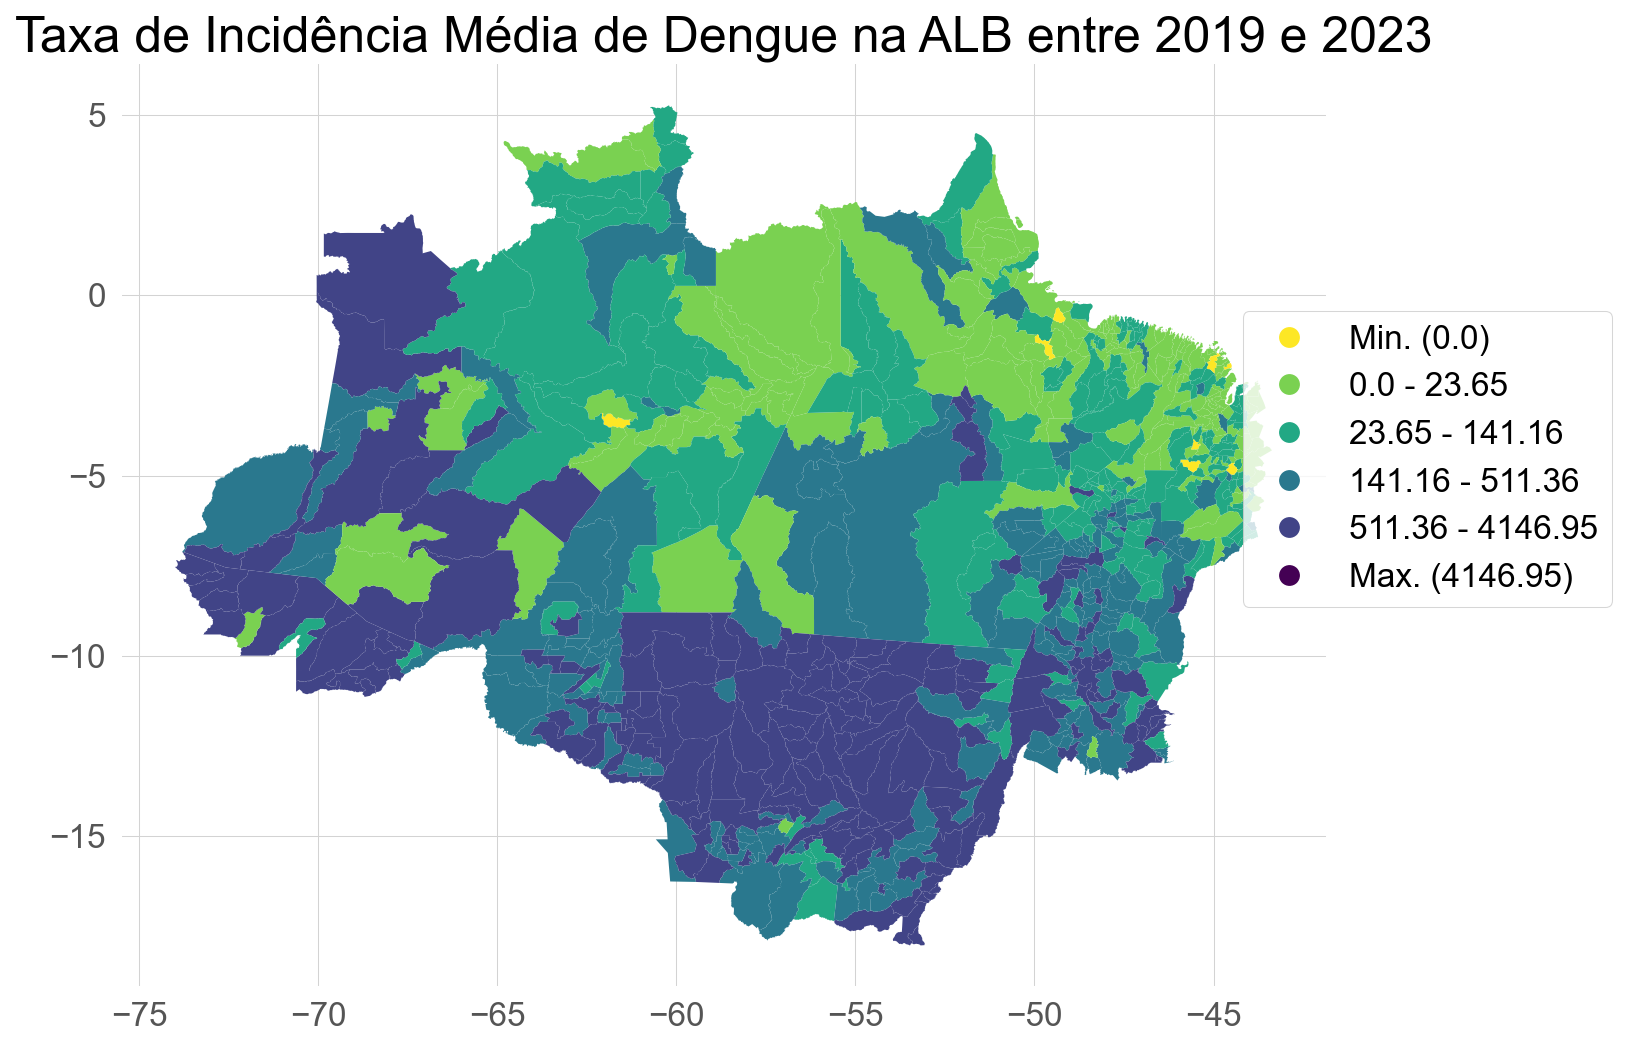

In [17]:
fig, ax = plt.subplots()

df2.plot(ax=ax, column='Category', cmap='viridis_r', legend=True)

ax.set_title('Taxa de Incidência Média de Dengue na ALB entre 2019 e 2023')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 0.75)) 
plt.show()

## 3. Data Statistics